In [3]:
import pandas as pd
import numpy as np
from numpy import random
from tqdm import tqdm_notebook, tqdm
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
import datetime

%matplotlib inline

class RandomWalk():
    """
    Defines a Random Walk model

    Inputs:

    data: takes a Pandas Series of (daily) values in a given time series
    """
    def __init__(self, data):
        self.data = data.pct_change()[1:] # get daily returns
        self.mu = self.data.mean()
        self.sigma = self.data.std()

    # Forecasting formula
    def random_walk(self, periods, start, mu = None, sigma = None):
        """
        returns end point of a Geometric Random Walk given
        starting value, drift, sigma, and number of periods

        Equation: # dS/S = mu dt + sigma dWt
        """
        if mu is None:
            mu = self.mu
        if sigma is None:
            sigma = self.sigma

        final_number = start
        for i in np.arange(periods):
            brownian = np.random.normal(loc=0.0, scale=1.0)*sigma
            drift = mu-0.5*sigma**2
            change = drift + brownian
            final_number = final_number*np.exp(change)
        return(final_number)

    def monte_carlo(self, periods, start, iterations = 1000):
        """
        Perform a given number of random walks
        to get a range of final point estimates
        """
        results = []
        iter = 0
        for i in tqdm(range(iterations)):
            result = self.random_walk(periods, start)
            results.append(result)
        return(list(results))

    def histogram(self, thresholds, mc_results):
        """
        Generates historgram based on pre-defined
        thresholds for the bins

        Meant to work with any number of thresholds (i.e. bins)
        """
        # calculate percentiles based on CDF
        percentiles = [percentileofscore(mc_results,i, kind = 'weak') \
        for i in thresholds]

        # return the probability for each bin
        return([round(i,3) for i in [percentiles[0],] + \
        [percentiles[i+1] - percentiles[i] for i in np.arange(len(thresholds)-1)] + \
        [100 - percentiles[-1],]])

    def plot_histogram(self, hist_results, thresholds):
        """
        Plots histogram based on inputted results
        """
        plt.figure(figsize=(10,6))
        # Labels for x axis
        x_labels = ['< ' + str(thresholds[0]),] + \
        [str(thresholds[i]) + '-' + str(thresholds[i+1]) \
        for i in np.arange(len(thresholds)-1)] + \
        ['> ' + str(thresholds[-1]),]
        # Plot
        plt.bar(x = x_labels, height = hist_results, align = 'center')
        plt.xticks(np.arange(len(x_labels)), x_labels, rotation='45')
        plt.ylabel('Probability', fontsize = 16)



100%|██████████| 100/100 [00:04<00:00, 24.14it/s]


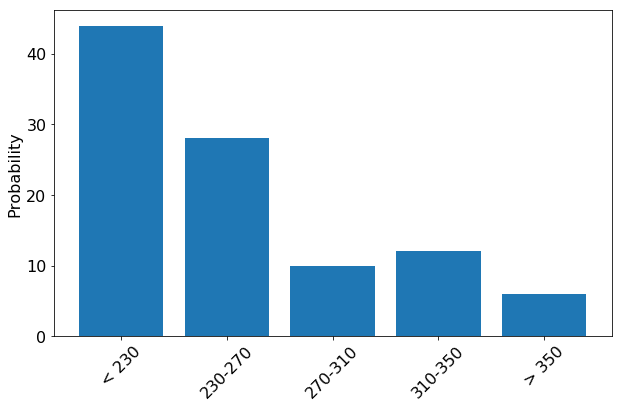

In [2]:
# Italy - Germany 10 year bond spread
# https://www.gjopen.com/questions/1205-what-will-the-italy-germany-10-year-bond-spread-be-on-20-october-2019

data_raw = pd.read_excel('./Data/ITDE_bond_spread.xlsx', index_col = 0)

model = RandomWalk(data_raw)

# Define current price
start = 216
# Define bins
thresholds = [230, 270, 310, 350]

# Define start and end of forecasting period
start_date = datetime.date( 2019, 8, 15 )
end_date = datetime.date( 2019, 10, 20 )
days = np.busday_count( start_date, end_date )

# Run model and get results
results = model.monte_carlo(periods = days, start = start, iterations = 100)

hist = model.histogram(thresholds = thresholds, mc_results = results)

model.plot_histogram(hist, thresholds = thresholds)